## Paper replication test
This notebook attemps to replicate the method from 2016:
Surangsrirat, Decho, et al. "Support vector machine classification of Parkinson's disease and essential tremor subjects based on temporal fluctuation." 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC). IEEE, 2016.

We use the features proposed in the paper, and a classificator coming from this paper.
We use the pre-processing pipeline establised previsouly, which corresponds to our EMG data.

In [14]:
# requirements
import os
import sys
sys.path.insert(0,'..') # to add parent directory
import random
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from utils.data_loader import PatientsRawData
from utils.preprocessing import preprocess_signal
from utils.augment_data import get_augmentation_indexes, augment_data
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay, accuracy_score


### load data

In [15]:
data = PatientsRawData('../../data/Исходные файлы - рассл/')
data.load_data()
print(f' Data labels: {data.Y} for the total of {len(data.X)} data samples coming from patients: {data.patient}')
print('Explore a random data sample: ')
N = random.randint(0,len(data.X))
data.X[N].head()
data.get_emg_data()

 Data labels: ['Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'ET', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right'] for the total of 41 data samples coming from patients: ['Аста0201.txt', 'Дюки0202.txt', 'Керш0203.txt', 'Лега0204.txt', 'Сидо0205.txt', 'Фрол0206.txt', 'Хвал0207.txt', 'Черк0208.txt', 'Даке0201.txt', 'Ершо0202.txt', 'Кудр0203.txt', 'Купр0204 .txt', 'Куту0205.txt', 'Лити0206.txt', 'Луче0207.txt', 'Макс0208.txt', 'Миро0209.txt', 'Молю02010.txt', 'Муха02011.txt', 'Соко02012.txt', 'Тихо02013.txt', 'Ерми0201.txt', 'Кова0202.txt', 'Колг0203.txt', 'Медв0204.txt', 'Наза0205.txt', 'Погр0206.txt', 'Савв0207.txt', 'Сави0208.txt', 'Шелу0209.txt', 'Бело0201.txt', 'Гава0202.txt', 'Голу0203.txt', 'Грек0204.txt', 'Губа0205.txt', 'Павл0206.txt', 'Пана0207.t

### pre-process  data
We use the same pre-processing as previously, but this time without applying the Hilber function.

In [16]:
# convert data to numpy
min_sequence = 10000000000
try:
    data.convert_to_numpy()
except:
    print('already converted, skipping!')
#preprocess all the data
for i in range(len(data.X)):
    one_patient_emg = data.X[i]
    for j, emg_channel in enumerate(one_patient_emg):
        if len(emg_channel)<min_sequence:
            min_sequence = len(emg_channel) 
        processed_signal =  preprocess_signal(emg_channel,  SamplingRate=500,  LF=60, HF=240, frequences_to_filter = [50, 100, 150, 200 ], order_butter=4, save_plot=False,apply_envelope=True) 
        data.X[i][j]=processed_signal # save to the previous unprocessed signal
    print(f'Pre-processed patient {i}') 
for i in range(len(data.X)):
    data.X[i]=data.X[i][:,:min_sequence] # save to the previous unprocessed signal

Pre-processed patient 0
Pre-processed patient 1
Pre-processed patient 2
Pre-processed patient 3
Pre-processed patient 4
Pre-processed patient 5
Pre-processed patient 6
Pre-processed patient 7
Pre-processed patient 8
Pre-processed patient 9
Pre-processed patient 10
Pre-processed patient 11
Pre-processed patient 12
Pre-processed patient 13
Pre-processed patient 14
Pre-processed patient 15
Pre-processed patient 16
Pre-processed patient 17
Pre-processed patient 18
Pre-processed patient 19
Pre-processed patient 20
Pre-processed patient 21
Pre-processed patient 22
Pre-processed patient 23
Pre-processed patient 24
Pre-processed patient 25
Pre-processed patient 26
Pre-processed patient 27
Pre-processed patient 28
Pre-processed patient 29
Pre-processed patient 30
Pre-processed patient 31
Pre-processed patient 32
Pre-processed patient 33
Pre-processed patient 34
Pre-processed patient 35
Pre-processed patient 36
Pre-processed patient 37
Pre-processed patient 38
Pre-processed patient 39
Pre-proces

### Select only hands from the data:
Since in the paper the EMG is taken from the hand, we will do the same here.
For Parkinson Left, the left hand is taken.
For Parkinson Right, the right hand is taken.
For ET the right hand is taken.

In [17]:
num_et = data.Y.count('ET')
num_pd = data.Y.count('Left') + data.Y.count('Right') 

In [18]:
parkinson_data = np.zeros((num_pd,min_sequence)) # PD
et_data = np.zeros((num_et, min_sequence)) # ET

In [19]:
n, m = 0, 0
patients_name_et = []
patients_name_pd = []
for i in range(len(data.Y)):
    if data.Y[i]=='ET':
        et_data[n] = data.X[i][1,:]     
        n+=1
        patients_name_et.append(data.patient[i])
    elif data.Y[i]=='Left':
         parkinson_data[m] = data.X[i][0,:]   
         m +=1
         patients_name_pd.append(data.patient[i])
    elif data.Y[i]=='Right':
        parkinson_data[m] = data.X[i][1,:]  
        m+=1  
        patients_name_pd.append(data.patient[i])
    

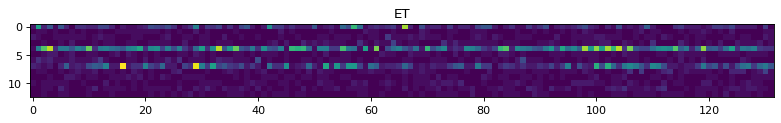

In [20]:
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(et_data[:,::500], interpolation='none')
plt.title('ET')
plt.show()

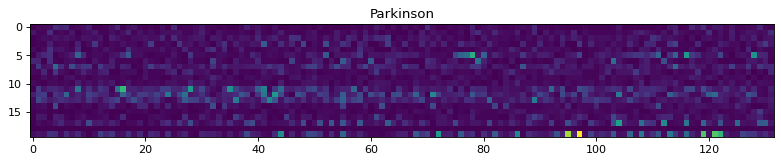

In [21]:
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(parkinson_data[:,::500], interpolation='none')
plt.title('Parkinson')
plt.show()

## Data exploration plots
Let's explore the data a bit more, to see if they correspond to the data in the paper.

#### Parkinson patient data plot

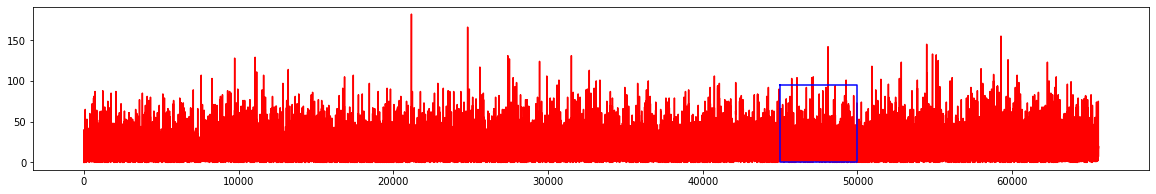

In [23]:
# take a random patient with Parkinson and plot the obtained signal on 10 plots
n = 17 #random.randint(0,20) 
patient_pd = parkinson_data[n,:]
# print(patient_pd.shape)
plt.figure(figsize=(20,3))
plt.plot(patient_pd, 'r')
# plot the zone 
coord = [[45000,95], [50000,95], [50000,0], [45000,0]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'
xs, ys = zip(*coord) #create lists of x and y values
plt.plot(xs,ys, 'b') 
plt.show()


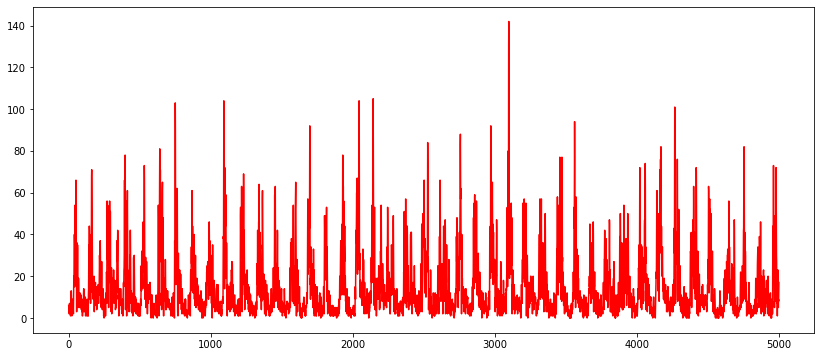

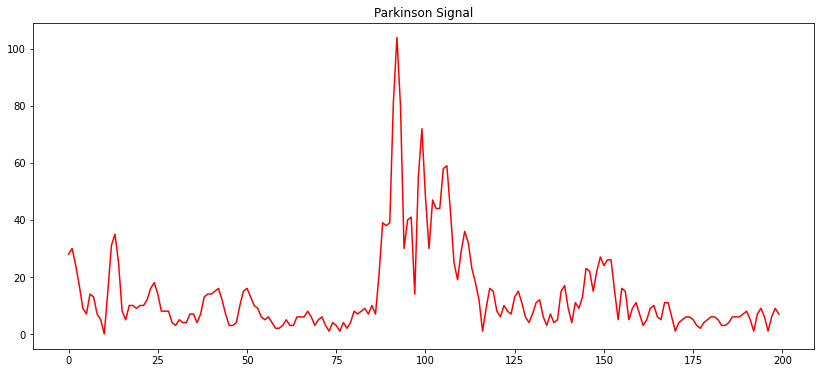

In [24]:
# plot only the selected part of a signal, first 5000
plt.figure(figsize=(14,6))
plt.plot(patient_pd[45000:50000],'r')
plt.show()
# and then just 200 items
plt.figure(figsize=(14,6))
plt.plot(patient_pd[46000:46200],'r')
plt.title('Parkinson Signal')
plt.show()

#### ET patient data plot

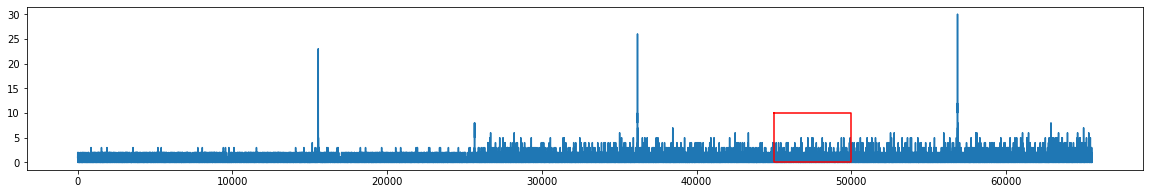

In [26]:
n = 10 #random.randint(0,20) 
patient_et = et_data[n,:]
# print(patient_pd.shape)
plt.figure(figsize=(20,3))
plt.plot(patient_et)
# plot the zone 
coord = [[45000,10], [50000,10], [50000,0], [45000,0]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'
xs, ys = zip(*coord) #create lists of x and y values
plt.plot(xs,ys, 'r') 
plt.show()

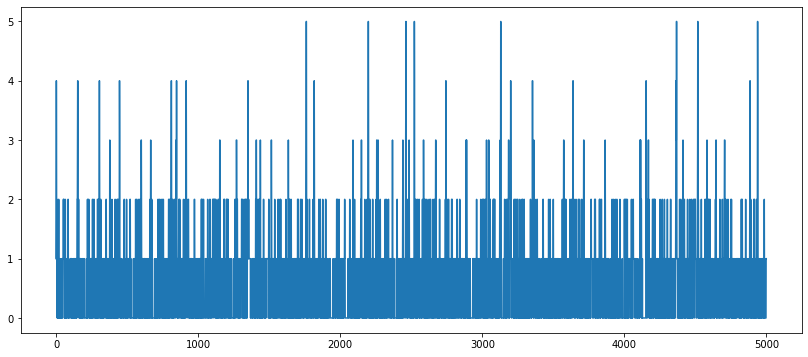

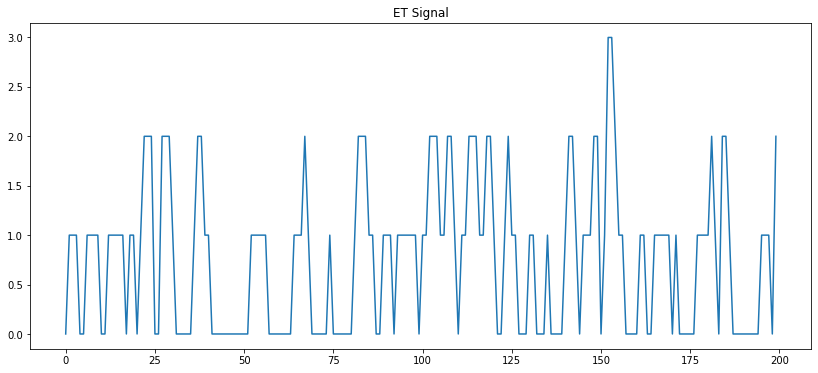

In [28]:
# plot only the selected part of a signal, first 5000
plt.figure(figsize=(14,6))
plt.plot(patient_et[45000:50000])
plt.show()
# and then just 200 items
plt.figure(figsize=(14,6))
plt.plot(patient_et[46000:46200])
plt.title('ET Signal')
plt.show()

Signals look very differently in case of these two patients.
Especially for the amplitute of the signal.
In the paper, the sequence length is 1250 samples. Let's use 5000 window used above to take signal parts.


### Let's now transform the hand data into the 2D features used in the paper.
According to the publication, the features are calculated in  the following way.
Suppose s(n) is a sample of tremor time series, d1 and d2 are delay units
which d1 < d2. 
Let f(n) = (x(n), y(n)) be a two-dimensional signal representing a relation of tremor samples at different delay units d1 and d2 as:

f(n) = (x(n), y(n)) = ((s(n+ d1)-s(n)), (s(n+ d2)-s(n)))

Suppose, for example, time-delay units d1 and d2 are selected to 20 and 40 samples.

In [29]:
# define feature proposed in the paper
def calculate_2D(signal, d1=20, d2=40):
    signal2d = np.zeros((2, len(signal)-d2))
    for i in range(len(signal)-d2):
        signal2d[0,i] = signal[i+d1]-signal[i]
        signal2d[1,i]= signal[i+d2]-signal[i]
    return signal2d

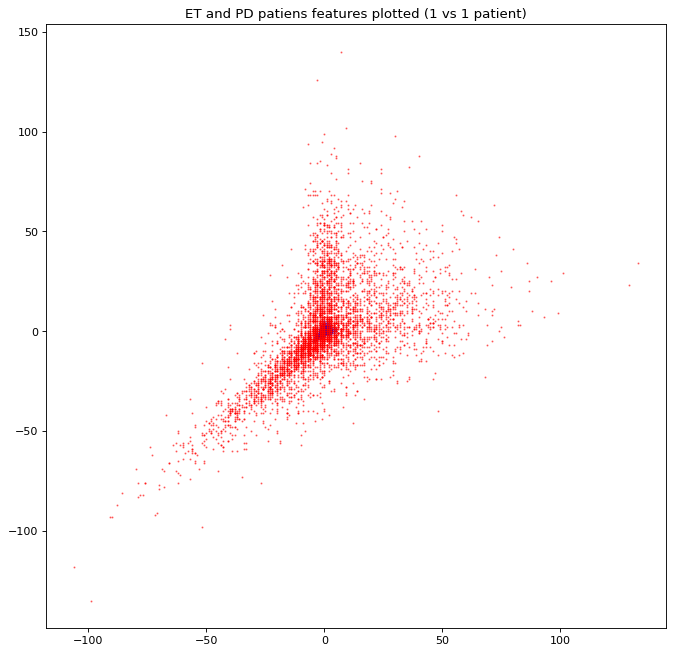

In [30]:
plt.figure(figsize=(10, 10), dpi=80)
transformed_et = calculate_2D(et_data[10])
transformed_pd=calculate_2D(parkinson_data[17])
# take cuts from signal
transformed_et = transformed_et[:,45000:50000]
transformed_pd = transformed_pd[:,45000:50000]
plt.scatter(transformed_et[0], transformed_et[1], c ="blue", alpha=0.5, s=0.7)
plt.scatter(transformed_pd[0], transformed_pd[1], c ="red",alpha=0.5, s=0.7)
# To show the plot
plt.title('ET and PD patiens features plotted (1 vs 1 patient)')
plt.show()

This sample looks rather good, however, if we will select another random pair, it can be different.

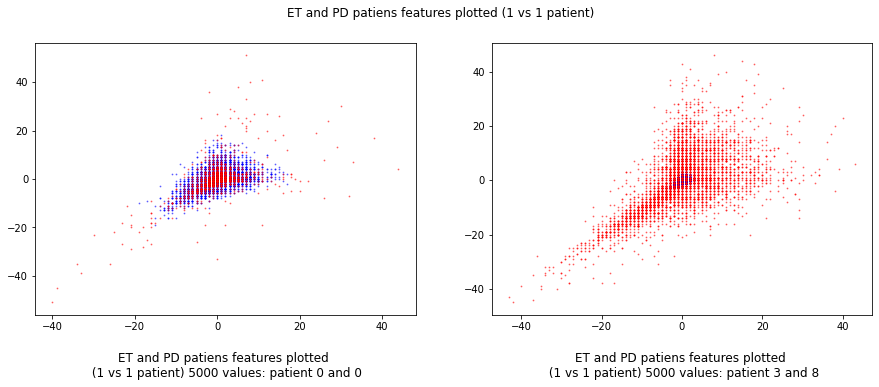

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
fig.suptitle('ET and PD patiens features plotted (1 vs 1 patient)')
transformed_et = calculate_2D(et_data[0])
transformed_pd=calculate_2D(parkinson_data[0])
# take cuts from signal
transformed_et = transformed_et[:,45000:50000]
transformed_pd = transformed_pd[:,45000:50000]
ax1.scatter(transformed_et[0], transformed_et[1], c ="blue", alpha=0.5, s=0.7)
ax1.scatter(transformed_pd[0], transformed_pd[1], c ="red",alpha=0.5, s=0.7)
# To show the plot
ax1.set_title('ET and PD patiens features plotted \n (1 vs 1 patient) 5000 values: patient 0 and 0',y=-0.25)
transformed_et = calculate_2D(et_data[3])
transformed_pd=calculate_2D(parkinson_data[8])
# take cuts from signal
transformed_et = transformed_et[:,45000:50000]
transformed_pd = transformed_pd[:,45000:50000]
ax2.scatter(transformed_et[0], transformed_et[1], c ="blue", alpha=0.5, s=0.7)
ax2.scatter(transformed_pd[0], transformed_pd[1], c ="red",alpha=0.5, s=0.7)
# To show the plot
ax2.set_title('ET and PD patiens features plotted \n (1 vs 1 patient) 5000 values: patient 3 and 8',y=-0.25)
plt.show()

This looks already less separable, moreover the ET patient values are much highter, than the PD, which was the case for the selected sample.

Whole data features:

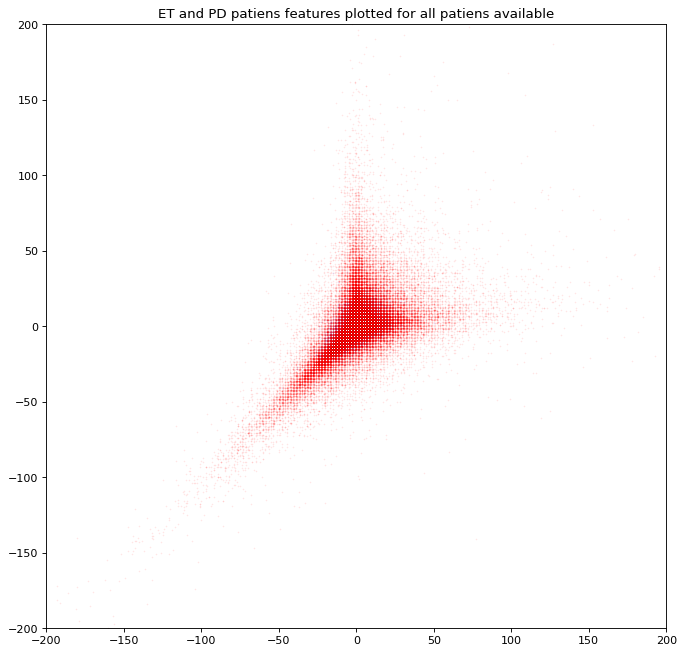

In [32]:
# let's try to get such features for all the data (whole length also), and plot them side by side.
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i])
    plt.scatter(transformed_et[0][::10], transformed_et[1][::10], c ="blue", alpha=0.2, s=0.05)
for j in range(len(parkinson_data)):
    transformed_pd=calculate_2D(parkinson_data[j])
    plt.scatter(transformed_pd[0][::10], transformed_pd[1][::10], c ="red",alpha=0.2, s=0.05)
# To show the plot
plt.xlim([-200, 200])
plt.ylim([-200, 200])
# plt.yscale('log')
# plt.xscale('log')
plt.title('ET and PD patiens features plotted for all patiens available')
plt.show()

From the relation between two different unit-delay
versions of tremor signal, we simply draw a 95%
confidence ellipse for each task of individual PD and ET

In [33]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **
    kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

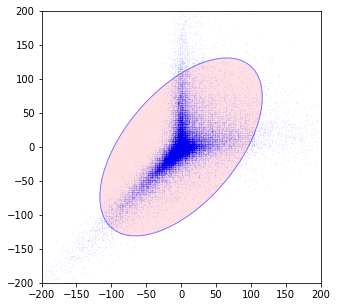

In [34]:
fig, ax_nstd = plt.subplots(figsize=(5, 5))
plt.scatter(transformed_pd[0], transformed_pd[1], c ="blue",alpha=0.2, s=0.01)
confidence_ellipse(transformed_pd[0], transformed_pd[1], ax_nstd, n_std=3,
                   label=r'$1\sigma$', edgecolor='blue',alpha=0.5, facecolor='pink',zorder=0)
plt.xlim([-200, 200])
plt.ylim([-200, 200])
plt.show()

Here is n example of the resulting data,  the confidence interval is equal to 95%.

In [35]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ellipse

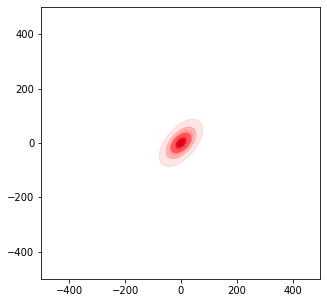

<Figure size 800x800 with 0 Axes>

In [36]:
et_ellipse = []
pd_ellipse = []
fig, ax = plt.subplots(figsize=(5, 5))
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i])
    #ax.scatter(transformed_et[0][::10], transformed_et[1][::10], c ="blue", alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_et[0], transformed_et[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='blue',alpha=0.3, facecolor='blue',zorder=0)
    ax.add_patch(el)
    et_ellipse.append([el.get_center(), el.width, el.height])

for j in range(len(parkinson_data)):
    transformed_pd=calculate_2D(parkinson_data[j])
#     ax.scatter(transformed_pd[0][::10], transformed_pd[1][::10], c ="red",alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_pd[0], transformed_pd[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='red',alpha=0.1, facecolor='red',zorder=0)
    ax.add_patch(el)
    pd_ellipse.append([el.get_center(), el.width, el.height])

ax.set_xlim([-500, 500])
ax.set_ylim([-500, 500])

plt.show()

In [37]:
pd_ellipse

[[(0, 0), 2.488579172854136, 1.3442372188109595],
 [(0, 0), 2.4949873532369766, 1.33230556074331],
 [(0, 0), 2.4404396700339515, 1.42977418389219],
 [(0, 0), 2.4981011655974315, 1.3264579022497298],
 [(0, 0), 2.4745825699134367, 1.3698325097181083],
 [(0, 0), 2.4750258237701095, 1.3690314721258567],
 [(0, 0), 2.513958073651918, 1.2961538504052432],
 [(0, 0), 2.470704733433093, 1.3768144828521052],
 [(0, 0), 2.5150118232706262, 1.2941080050787723],
 [(0, 0), 2.494216915422667, 1.3337473444470043],
 [(0, 0), 2.47605254406331, 1.3671736535779242],
 [(0, 0), 2.441161005348153, 1.4285422450762855],
 [(0, 0), 2.495101583513975, 1.3320916214532899],
 [(0, 0), 2.44294761597559, 1.4254848107220157],
 [(0, 0), 2.454099610605261, 1.4061988128380383],
 [(0, 0), 2.4597641644275385, 1.396266541673936],
 [(0, 0), 2.5284408001868357, 1.2676699570276777],
 [(0, 0), 2.515030777766361, 1.2940711676287104],
 [(0, 0), 2.449404908442719, 1.414360489584149],
 [(0, 0), 2.499796059402676, 1.323260995191369]]

In [38]:
et_ellipse

[[(0, 0), 2.4358275171990558, 1.437617580045501],
 [(0, 0), 2.448372867589106, 1.4161462852592233],
 [(0, 0), 2.4481216617516037, 1.4165805057470495],
 [(0, 0), 2.4547048521831885, 1.4051420172595759],
 [(0, 0), 2.4513788258647757, 1.4109365159715135],
 [(0, 0), 2.4475065675404646, 1.4176429740404646],
 [(0, 0), 2.476210202833789, 1.3668880829760155],
 [(0, 0), 2.4413561420891554, 1.428208733863351],
 [(0, 0), 2.4555634343775274, 1.403641058015917],
 [(0, 0), 2.446827104512183, 1.4188153934266872],
 [(0, 0), 2.4558239621034565, 1.4031851863380262],
 [(0, 0), 2.450345820725896, 1.4127297543589628],
 [(0, 0), 2.4481146898356805, 1.4165925544809101]]

# MANUAL SELECTION OF DATA SAMPLES FROM PATIENTS
Previous tests have shown that it is impossible to select a random part of a singal in order to classify PD and ET using the method proposed in the studed paper.
Therefore, we manually select the most characteristic parts from each patient to use them.


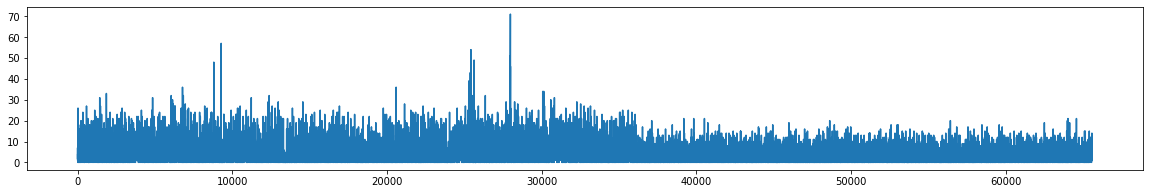

Enter the coordinates of selected signal part (START, END):
40000,50000


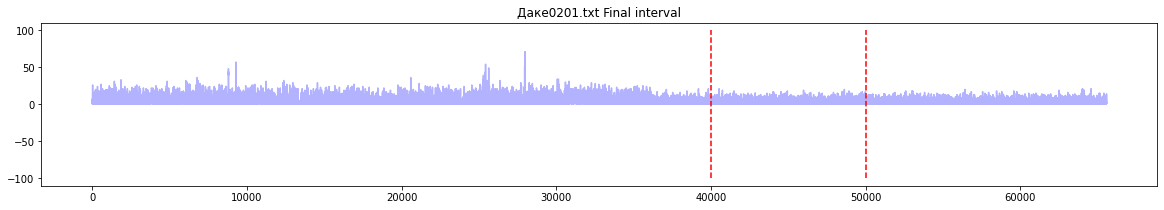

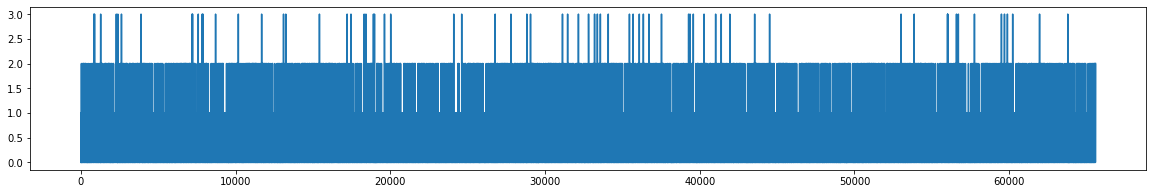

Enter the coordinates of selected signal part (START, END):
40000,50000


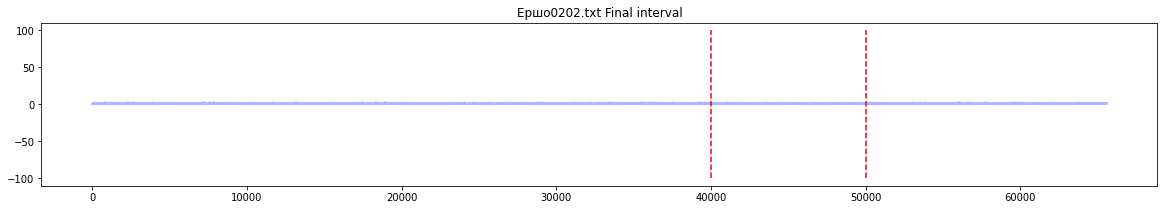

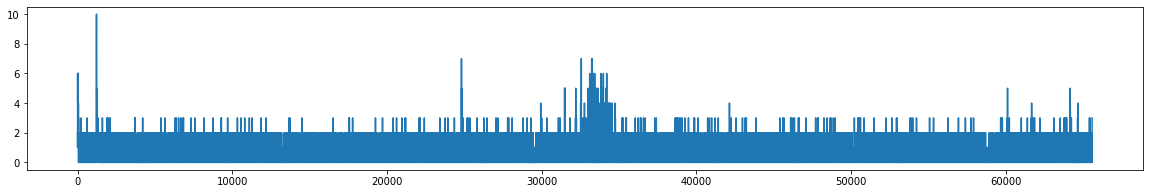

Enter the coordinates of selected signal part (START, END):
40000,50000


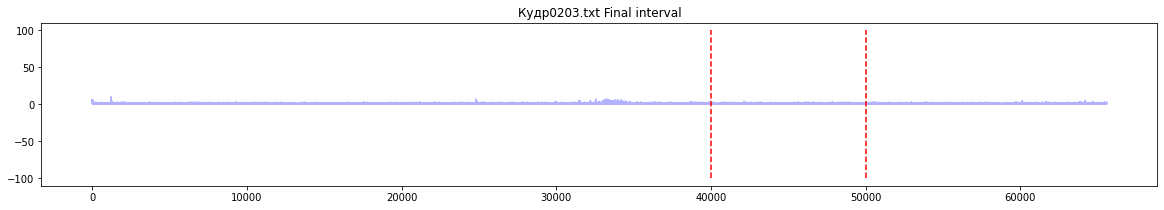

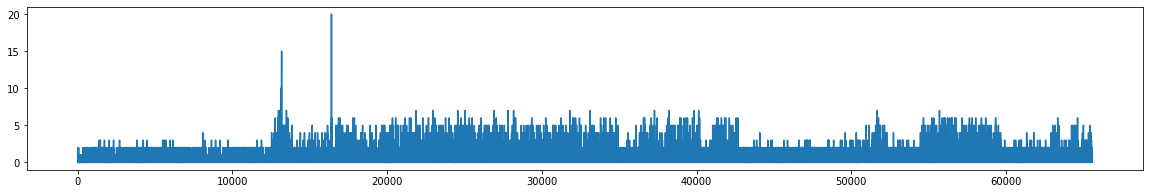

Enter the coordinates of selected signal part (START, END):
0,10000


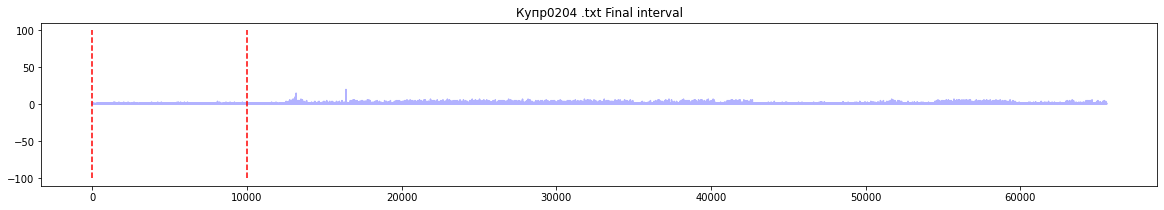

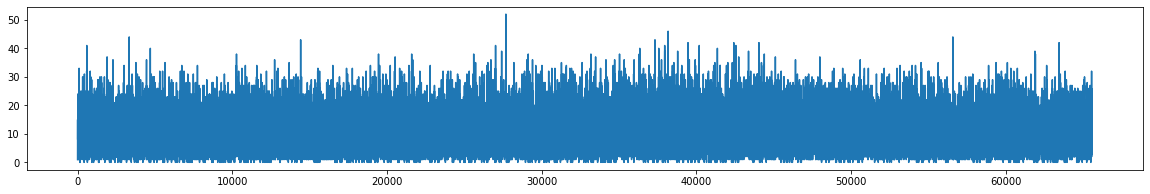

Enter the coordinates of selected signal part (START, END):
0,10000


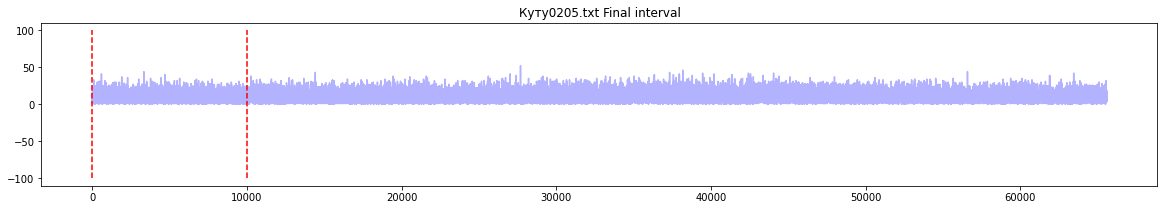

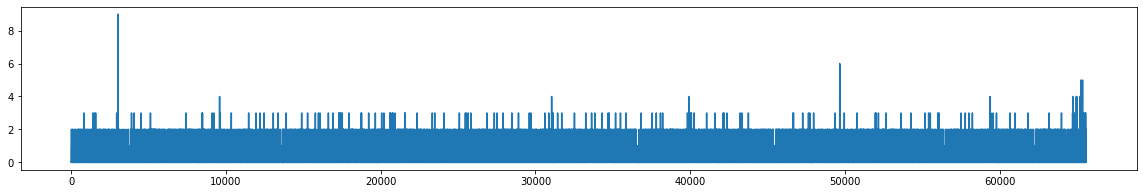

Enter the coordinates of selected signal part (START, END):
10000,20000


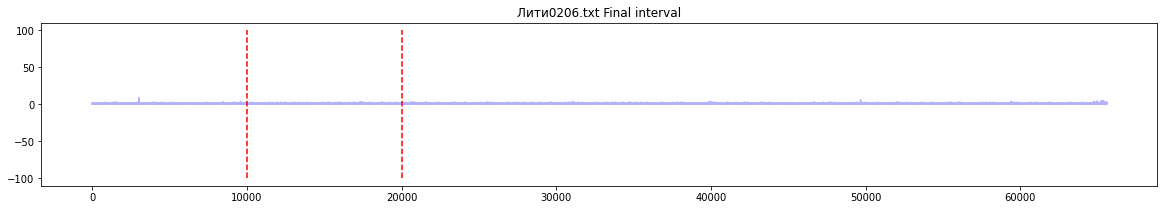

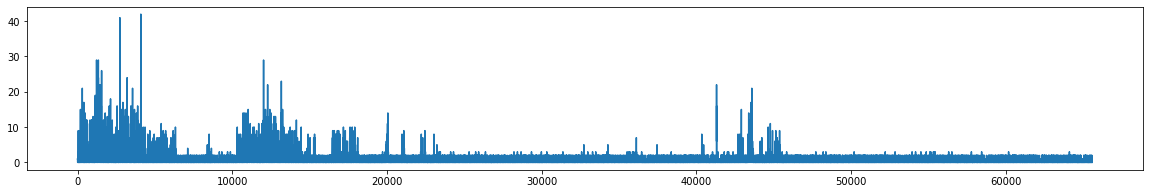

Enter the coordinates of selected signal part (START, END):
20000,30000


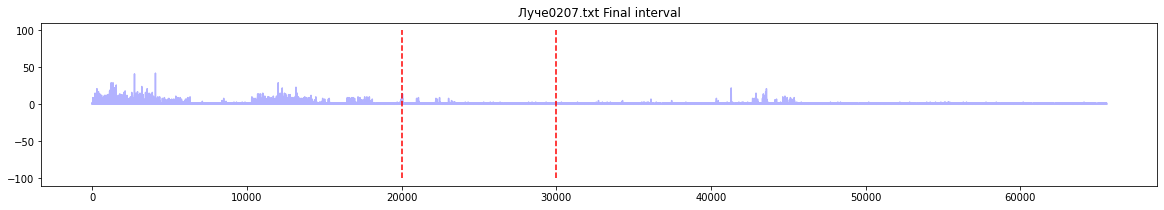

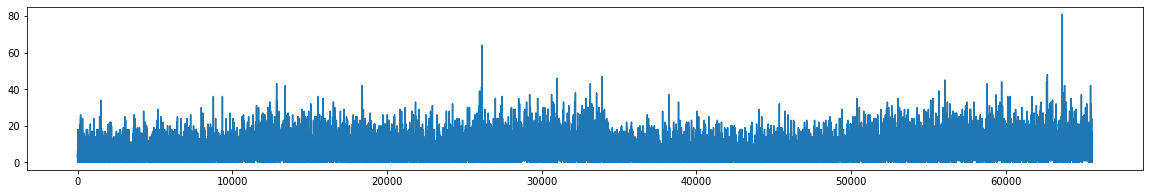

Enter the coordinates of selected signal part (START, END):
10000,20000


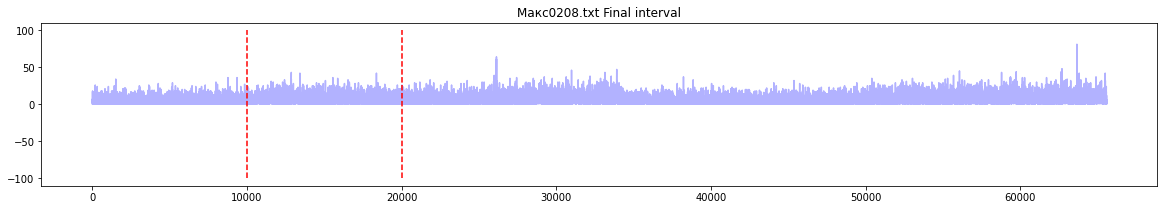

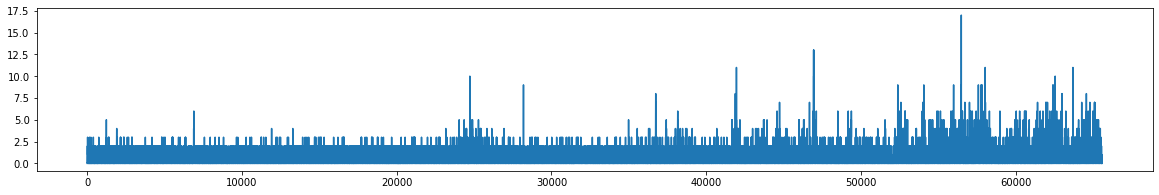

Enter the coordinates of selected signal part (START, END):
10000,20000


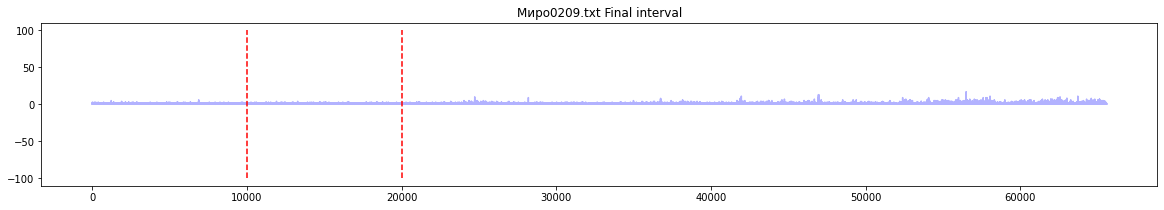

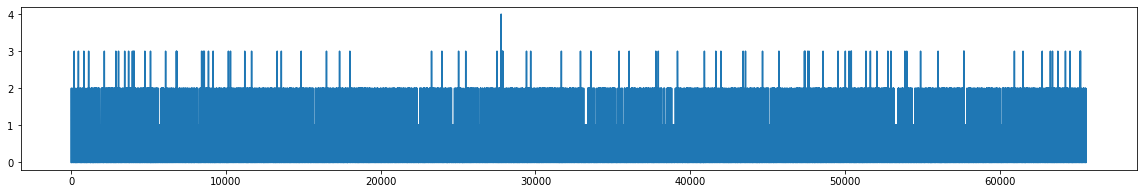

Enter the coordinates of selected signal part (START, END):
10000,20000


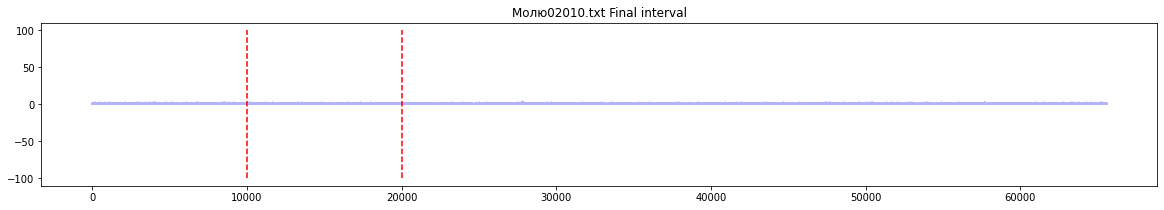

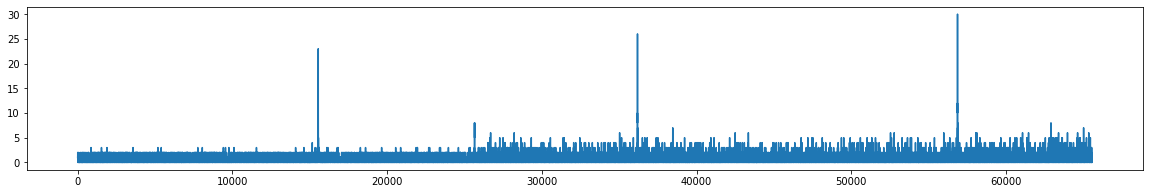

Enter the coordinates of selected signal part (START, END):
20000,30000


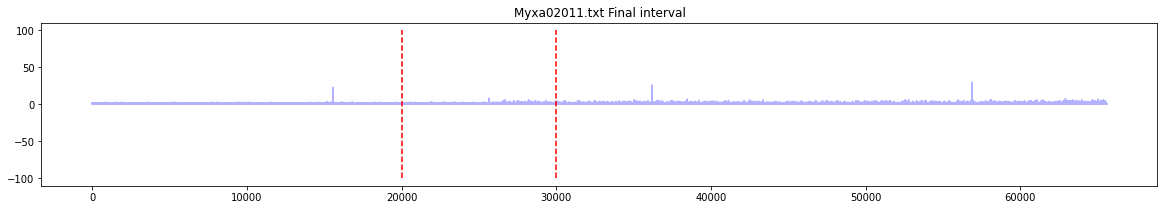

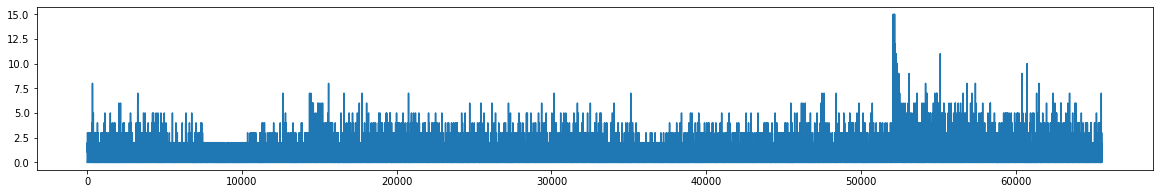

Enter the coordinates of selected signal part (START, END):
30000,40000


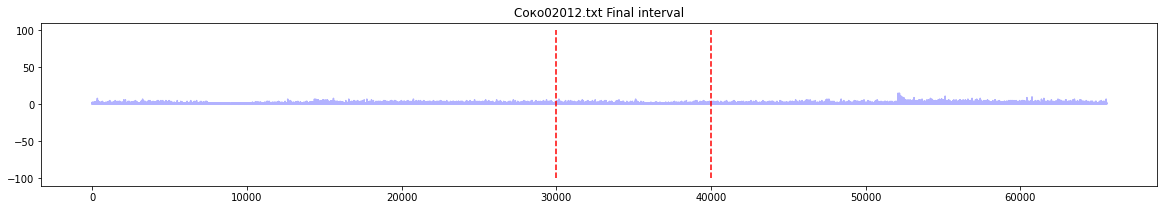

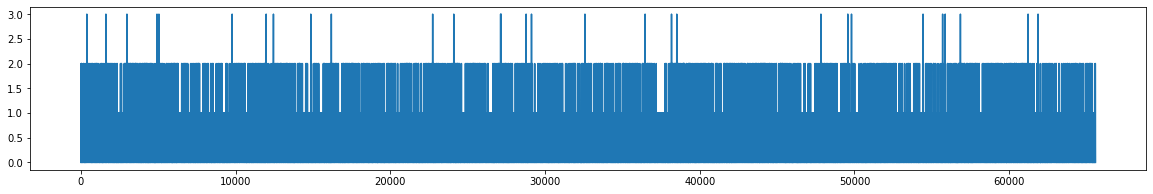

Enter the coordinates of selected signal part (START, END):
10000,20000


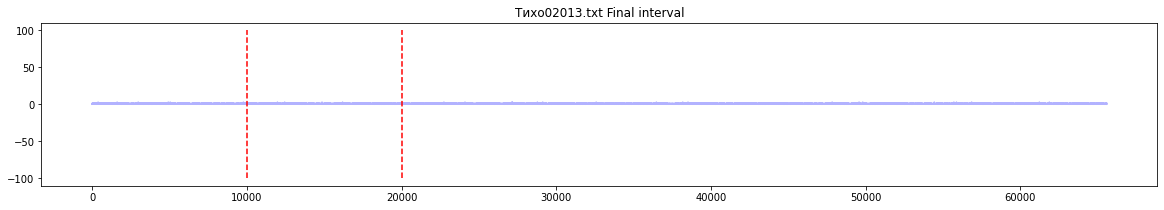

In [39]:
coordinates_selected_et = np.zeros((len(et_data),2))
for n in range(len(et_data)):
    patient_et = et_data[n,:]
    # print(patient_pd.shape)    
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(patient_et)
    plt.show()
    print('Enter the coordinates of selected signal part (START, END):')
    x = input()
    values = x.split(',')
    coordinates_selected_et[n,0]=int(values[0])
    coordinates_selected_et[n,1]=int(values[1])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(patient_et, 'b', alpha = 0.3)
    ax.vlines([coordinates_selected_et[n,0], coordinates_selected_et[n,1]], -100, 100, linestyles='dashed', colors='red')
    ax.set_title(f"{patients_name_et[n]} Final interval")
    fig.show()
    
    

In [26]:
import csv
# save selected intervals
# with open('pd_intervals.csv', 'w') as f: 
#     write = csv.writer(f) 
#     write.writerows(coordinates_selected_pd) 

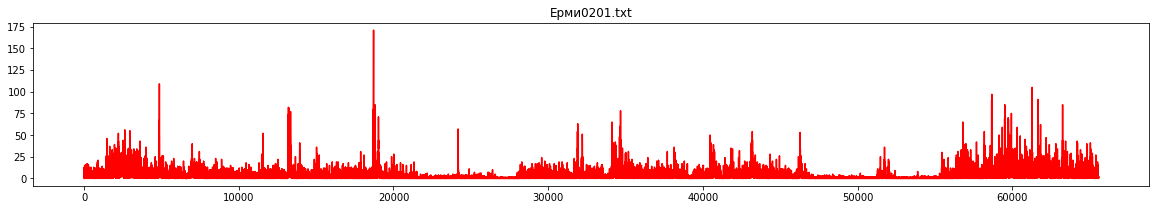

Enter the coordinates of selected signal part (START, END):
10000,20000


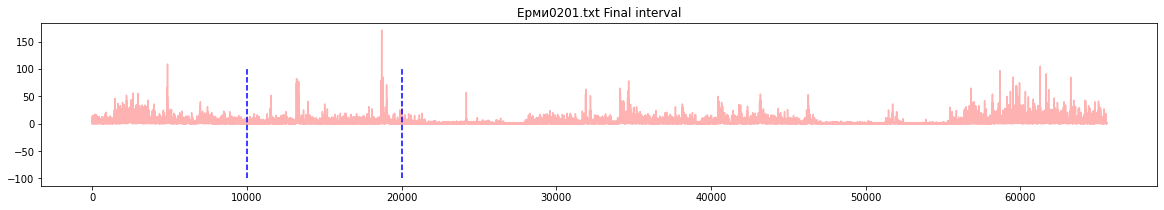

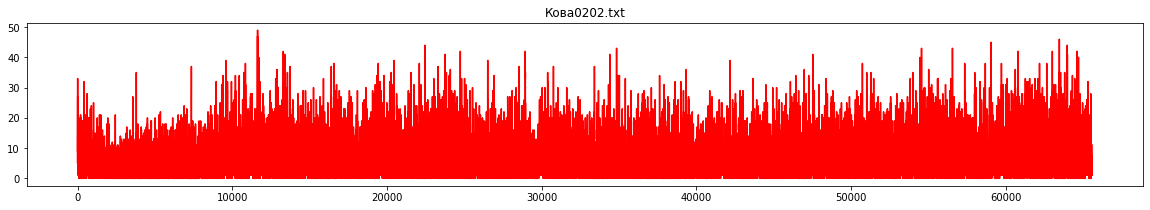

Enter the coordinates of selected signal part (START, END):
10000,20000


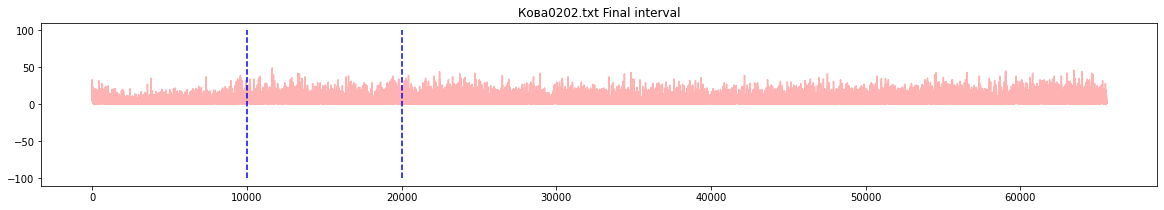

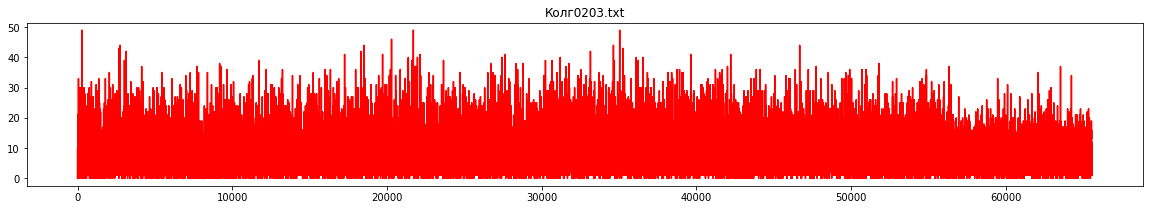

Enter the coordinates of selected signal part (START, END):
10000,20000


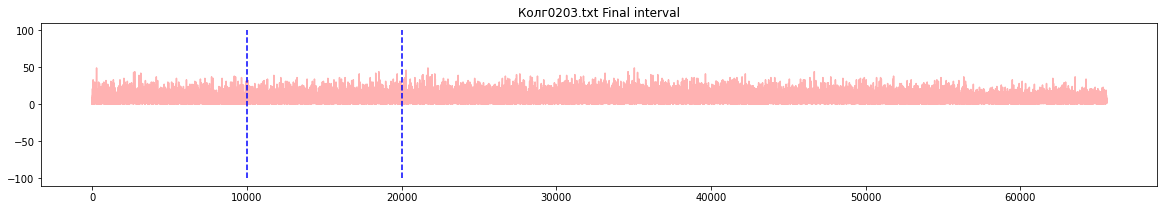

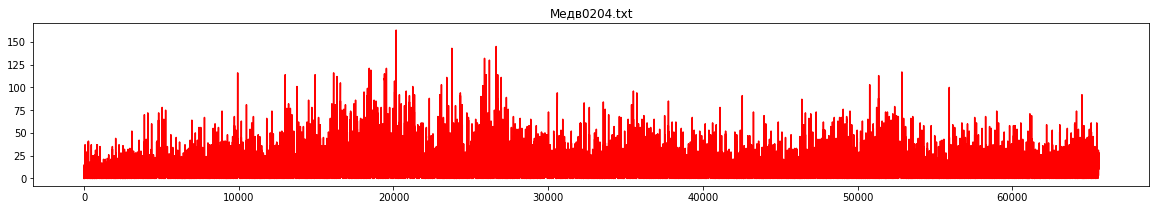

Enter the coordinates of selected signal part (START, END):
20000,30000


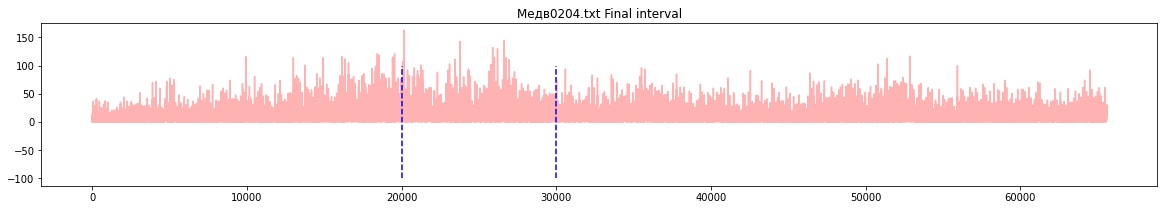

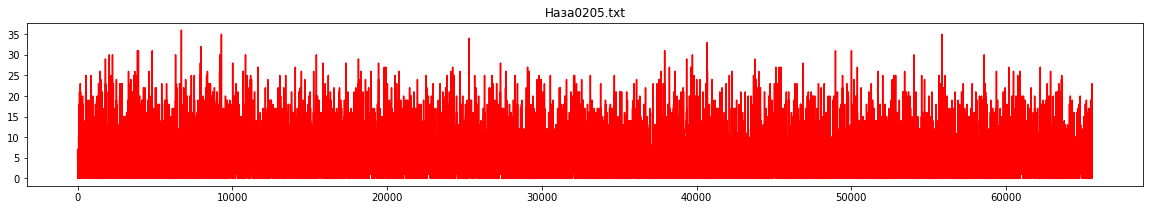

Enter the coordinates of selected signal part (START, END):
10000,20000


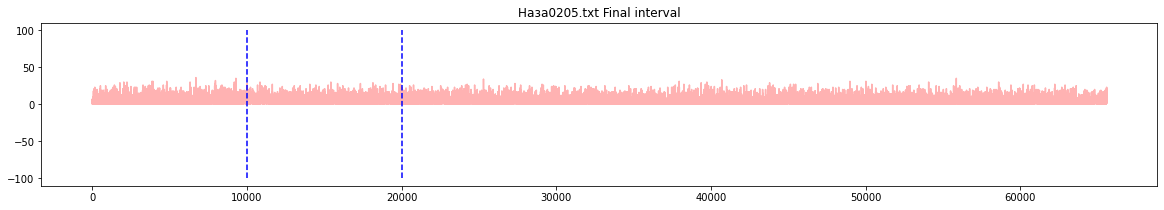

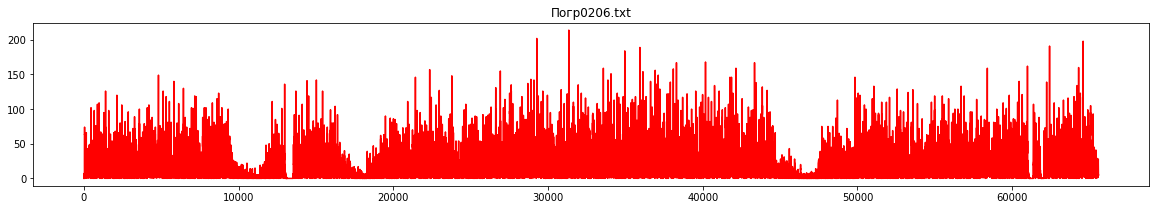

Enter the coordinates of selected signal part (START, END):
20000,30000


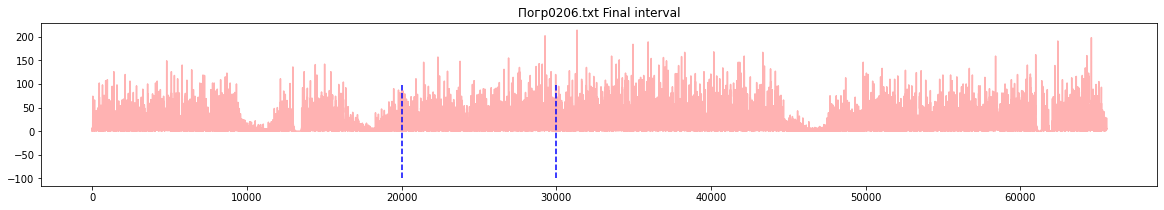

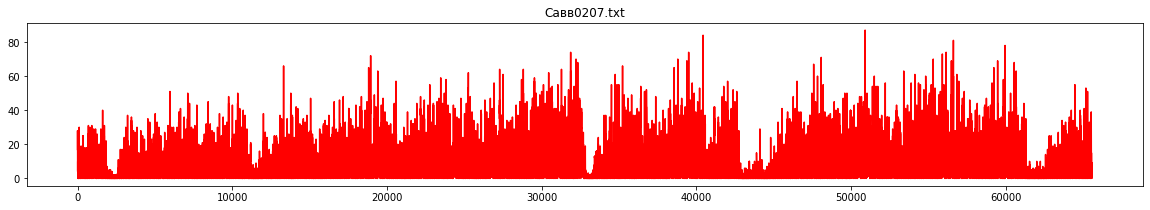

Enter the coordinates of selected signal part (START, END):
40000,50000


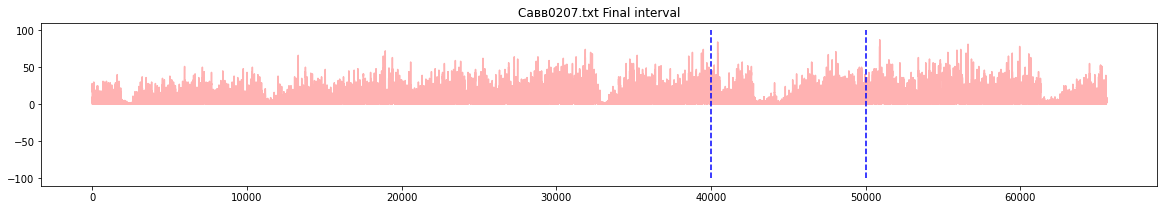

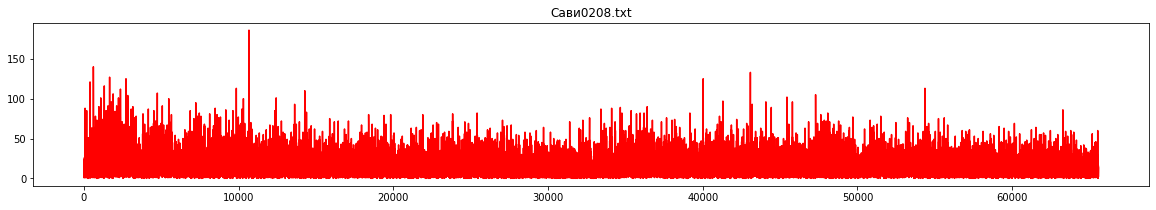

Enter the coordinates of selected signal part (START, END):
0,10000


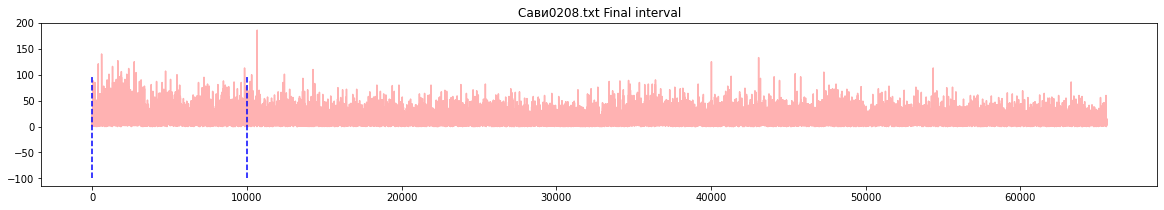

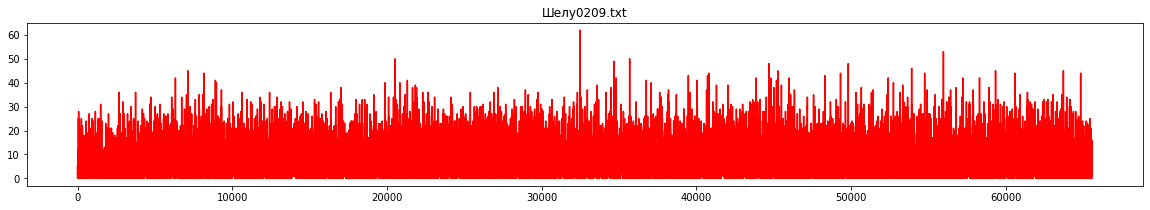

Enter the coordinates of selected signal part (START, END):
30000,40000


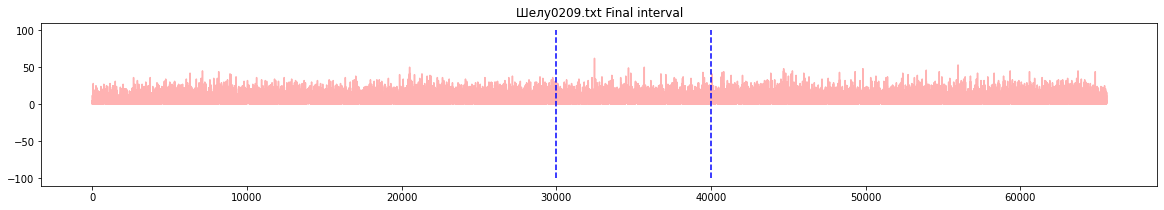

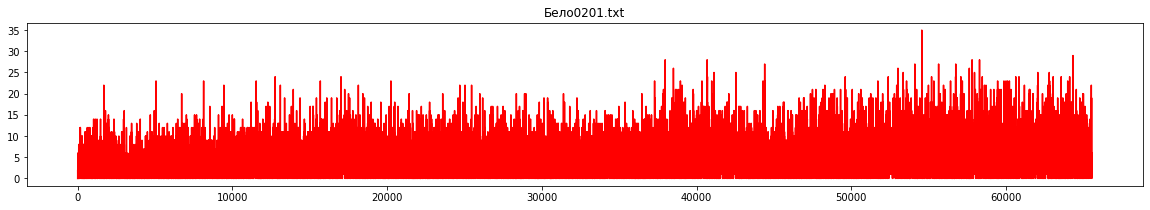

Enter the coordinates of selected signal part (START, END):
50000,60000


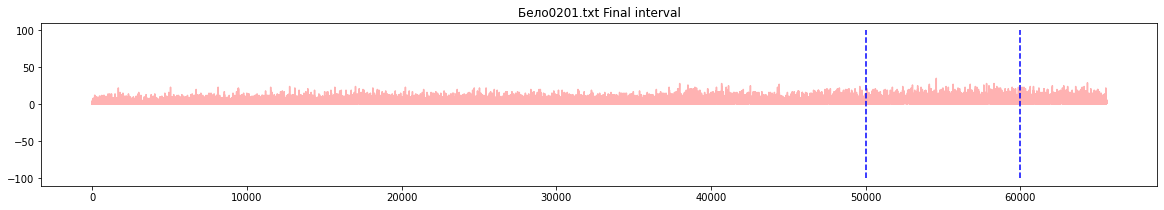

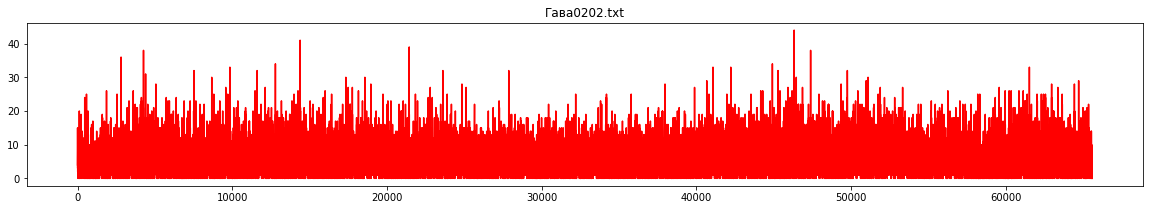

Enter the coordinates of selected signal part (START, END):
40000,50000


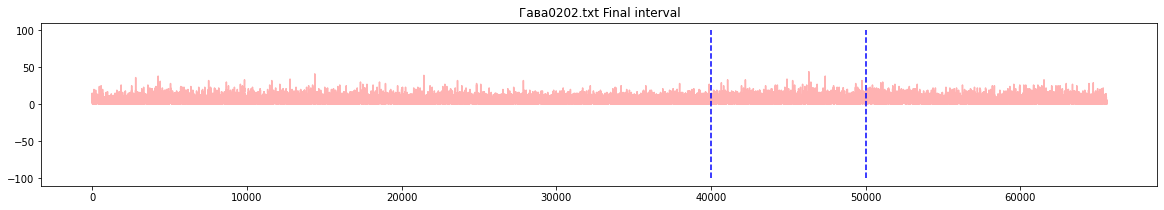

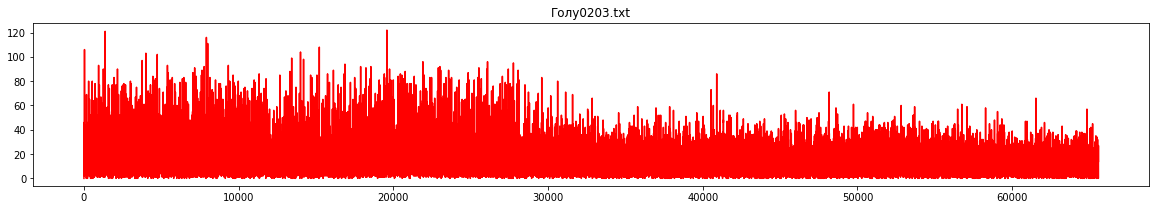

Enter the coordinates of selected signal part (START, END):
0,10000


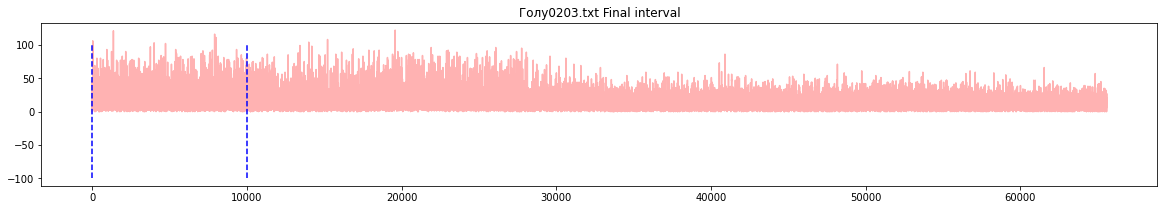

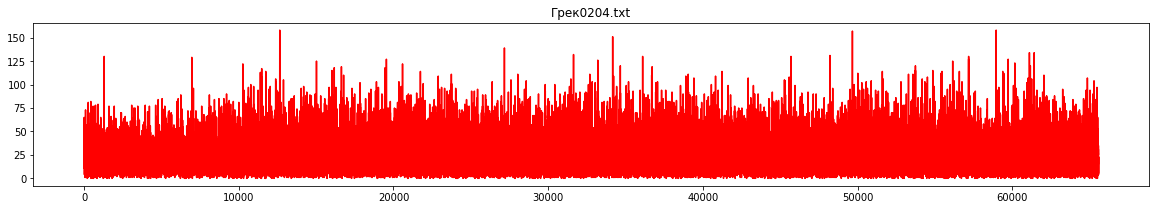

Enter the coordinates of selected signal part (START, END):
50000,60000


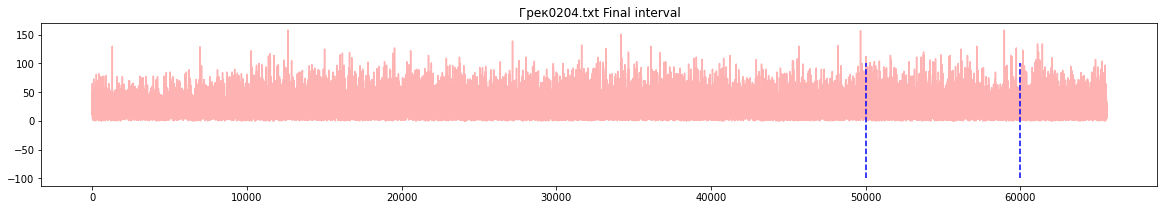

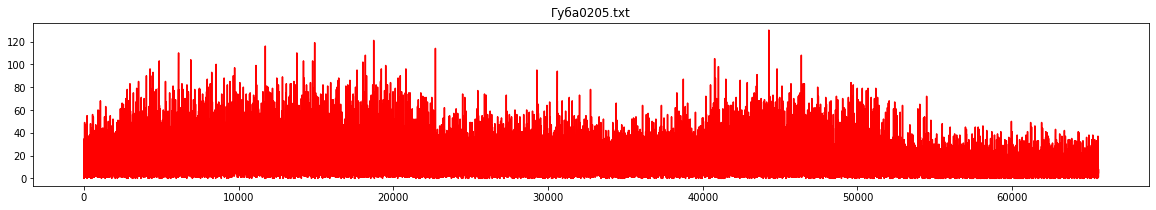

Enter the coordinates of selected signal part (START, END):
40000,50000


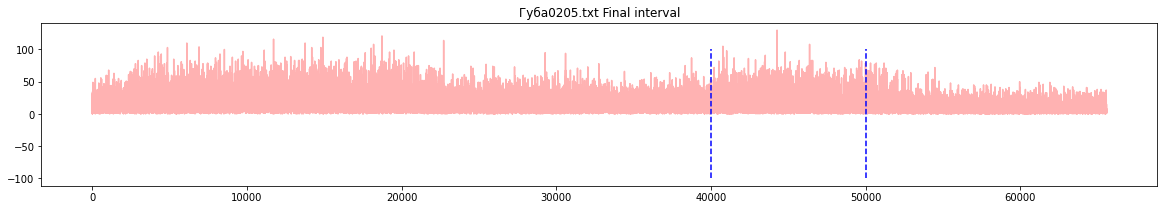

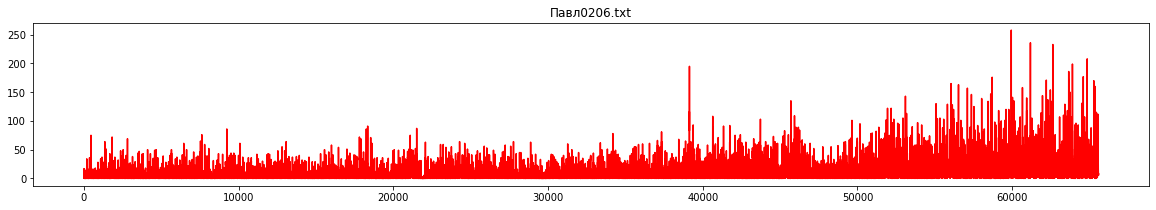

Enter the coordinates of selected signal part (START, END):
40000,50000


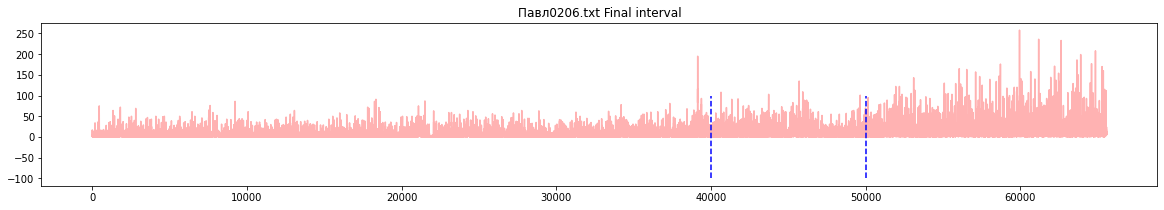

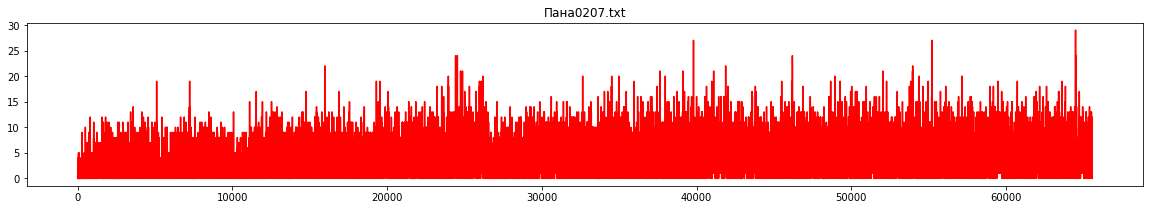

Enter the coordinates of selected signal part (START, END):
20000,30000


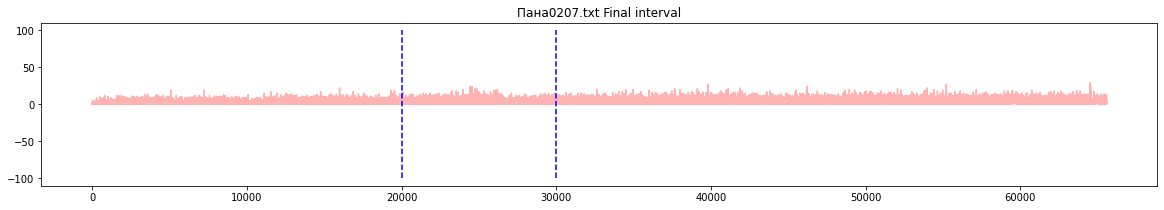

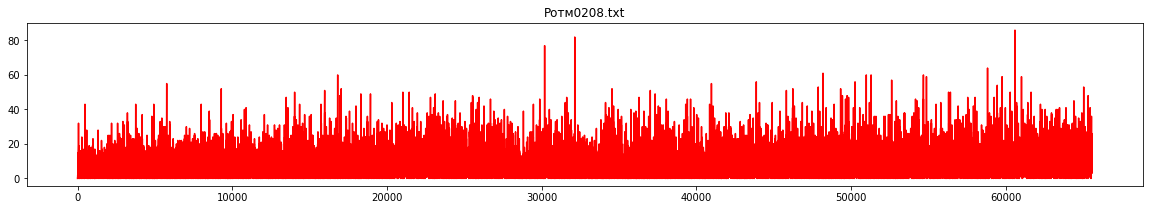

Enter the coordinates of selected signal part (START, END):
30000,40000


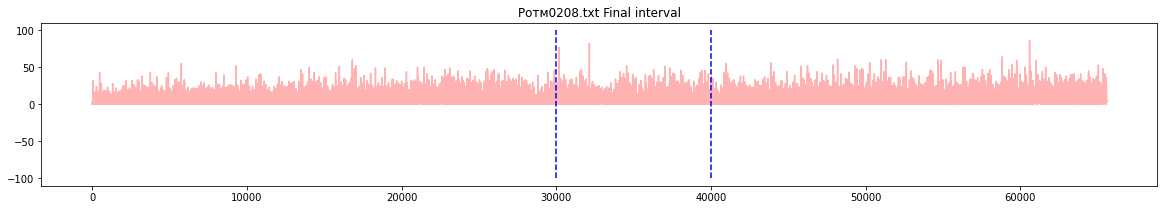

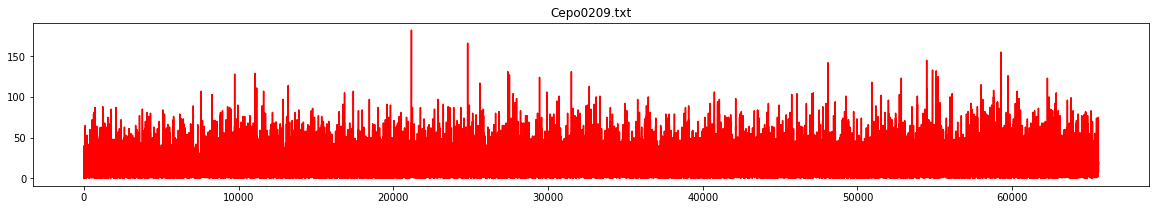

Enter the coordinates of selected signal part (START, END):
20000,30000


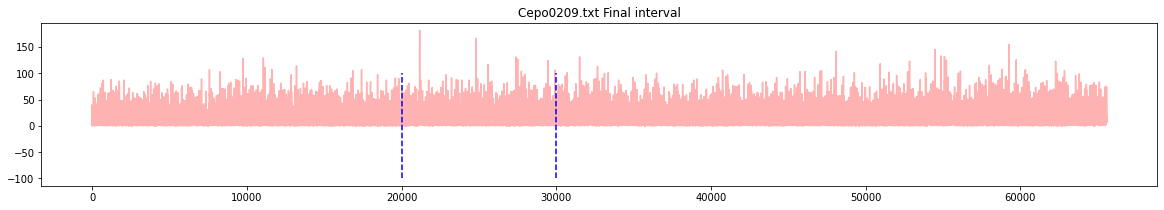

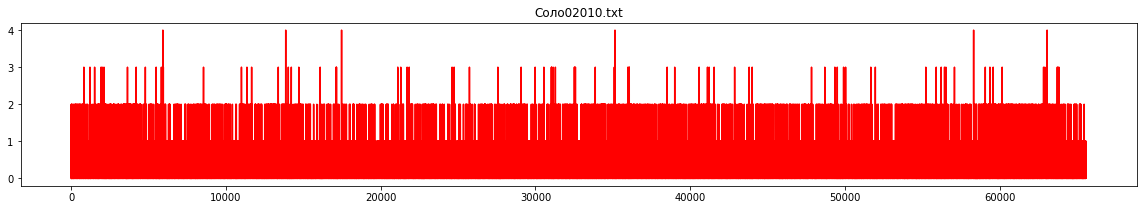

Enter the coordinates of selected signal part (START, END):
20000,30000


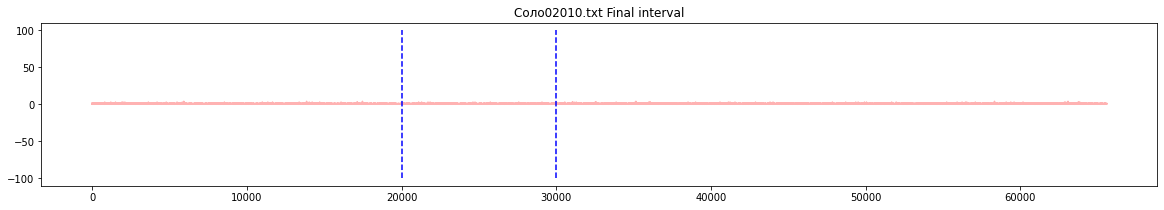

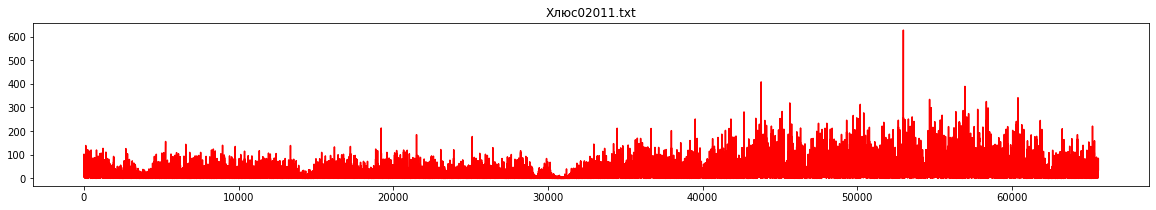

Enter the coordinates of selected signal part (START, END):
50000,60000


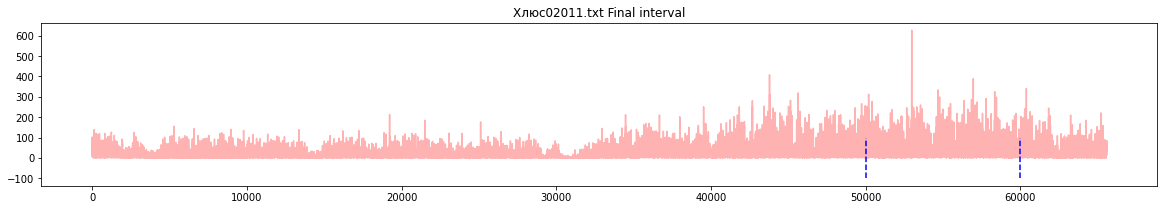

In [40]:
coordinates_selected_pd = np.zeros((len(parkinson_data),2), dtype=int)
for n in range(len(parkinson_data)):
    patient_pd = parkinson_data[n,:]
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(patient_pd, 'r')
    ax.set_title(patients_name_pd[n])
    plt.show()
    print('Enter the coordinates of selected signal part (START, END):')
    x = input()
    fig, ax = plt.subplots(figsize=(20,3))
    ax.plot(patient_pd, 'r', alpha = 0.3)
    values = x.split(',')
    coordinates_selected_pd[n,0]=int(values[0])
    coordinates_selected_pd[n,1]=int(values[1])
    ax.vlines([coordinates_selected_pd[n,0], coordinates_selected_pd[n,1]], -100, 100, linestyles='dashed', colors='blue')
    ax.set_title(f"{patients_name_pd[n]} Final interval")
    fig.show()

## Test the method on the selected coordinates

In [ ]:
# TODO: dynamic display: https://www.geeksforgeeks.org/how-to-update-a-plot-on-same-figure-during-the-loop/

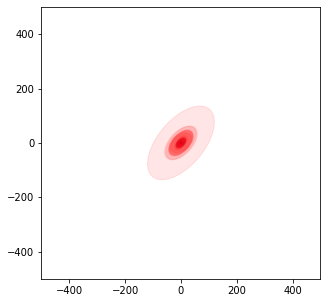

<Figure size 800x800 with 0 Axes>

In [41]:
et_transformed = []
pd_transformed = []
fig, ax = plt.subplots(figsize=(5, 5))
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i,int(coordinates_selected_et[i][0]):int(coordinates_selected_et[i][1])])
    #ax.scatter(transformed_et[0][::10], transformed_et[1][::10], c ="blue", alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_et[0], transformed_et[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='blue',alpha=0.2, facecolor='blue',zorder=0)
    ax.add_patch(el)
    et_transformed.append(transformed_et)

for j in range(len(parkinson_data)):
    transformed_pd=calculate_2D(parkinson_data[j,int(coordinates_selected_pd[j][0]):int(coordinates_selected_pd[j][1])])
#     ax.scatter(transformed_pd[0][::10], transformed_pd[1][::10], c ="red",alpha=0.2, s=0.05)
    el = confidence_ellipse(transformed_pd[0], transformed_pd[1], ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='red',alpha=0.1, facecolor='red',zorder=0)
    ax.add_patch(el)
    pd_transformed.append(transformed_pd)

ax.set_xlim([-500, 500])
ax.set_ylim([-500, 500])

plt.show()

[0.00050201 0.00140562] [4.22548442 3.97838008]
[-0.0002008  0.0003012] [0.83977428 0.84293658]
[-0.00060241  0.00050201] [0.93568245 0.91039278]
[-0.00050201 -0.00090361] [0.86294754 0.87393032]
[0.01034137 0.0063253 ] [8.55150903 8.41888178]
[0.00050201 0.00070281] [0.887836   0.89414624]
[-0.00542169 -0.01325301] [1.06861521 1.09920794]
[-0.00281124  0.00140562] [7.25922707 7.14973235]
[0.0001004  0.00060241] [0.93745147 0.93761191]
[0.00070281 0.00070281] [0.86026725 0.8565244 ]
[-0.0003012 -0.0002008] [1.0522017  1.05567883]
[-0.00050201 -0.00190763] [1.21581767 1.22092547]
[-0.00120482 -0.00070281] [0.81993152 0.81938089]


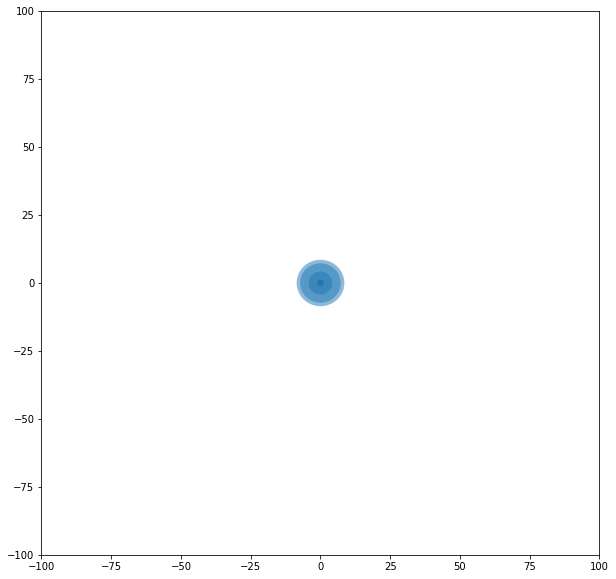

In [42]:
# calculate mu and 2 sigma of each ET
from matplotlib.patches import Circle
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))
for e in et_transformed:
    print(np.mean(e,1), np.std(e,1))
    p = Circle(np.mean(e,1), np.std(e,1)[0], alpha=0.5)
    ax.add_patch(p)

[0.00742972 0.0065261 ] [7.97996645 8.68973553]
[0.00491968 0.00672691] [8.49174392 9.31768921]
[-0.00170683  0.00230924] [8.90720215 8.73594653]
[ 0.0001004  -0.00502008] [20.15280233 22.73406532]
[-0.00050201 -0.0187751 ] [6.16870419 6.43067362]
[0.02700803 0.03222892] [29.3595488  31.24964362]
[0.03594378 0.05562249] [11.55230437 13.36487178]
[0.04006024 0.07178715] [22.15149785 23.37578397]
[0.0001004  0.00160643] [ 9.0561446  10.51777981]
[0.00803213 0.02309237] [5.76456909 6.50602662]
[0.00763052 0.00562249] [6.23401909 6.76927328]
[0.01455823 0.0062249 ] [21.95147279 21.85563168]
[-0.0062249   0.03714859] [27.0076027  30.29060761]
[-0.00953815 -0.00512048] [19.76146938 19.22167435]
[-0.00120482  0.05823293] [17.43129942 17.67680117]
[0.00512048 0.0061245 ] [3.95284376 4.03320339]
[-0.00512048 -0.00240964] [ 9.5329314  11.15592276]
[ 0.00431727 -0.02841365] [21.20675807 24.13018357]
[-0.0001004   0.00190763] [0.77673241 0.78252524]
[0.00833333 0.00110442] [59.91836004 67.81955816

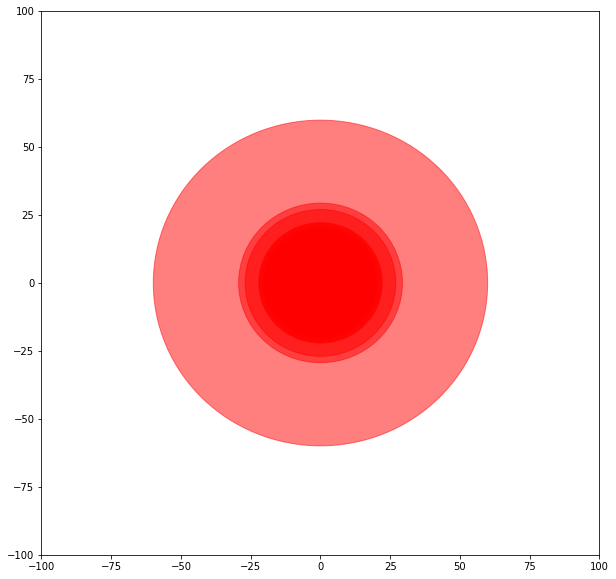

In [43]:
# calculate mu and 2 sigma of each ET
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))
for e in pd_transformed:
    print(np.mean(e,1), np.std(e,1))
    p = Circle(np.mean(e,1), np.std(e,1)[0], alpha=0.5, color='r')
    ax.add_patch(p)

# Visualisation with the historgrams

To simplify a bit, I take not the area of an ellipse, as proposed by the authors, but the area of a circle with 2 std, which means that the formula I use is:

feature = Pi (2sigma)^2

It means that in the end we can just compare 2 sigmas values, which I do in the following.
Before applying a classification, pure visual analysis is performed, SVM is left for the next stage.


In [44]:
et_feature=np.zeros((len(et_transformed),2))
for i, e in enumerate(et_transformed):
    et_feature[i,:]=np.std(e,1)*2 


Text(0.5, 1.0, '2 variances box plots for ET patients')

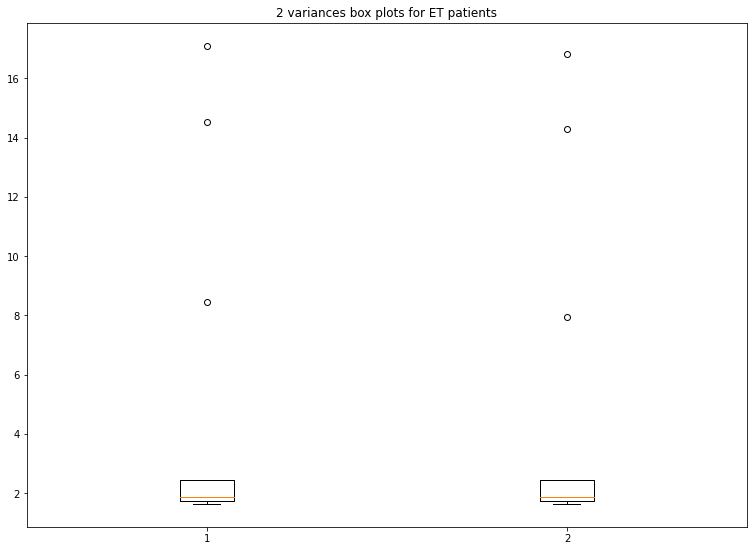

In [45]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(et_feature)
ax.set_title('2 variances box plots for ET patients')

In [46]:
pd_feature=np.zeros((len(pd_transformed),2))
for i, e in enumerate(pd_transformed):
    pd_feature[i,:]=np.std(e,1)*2 


Text(0.5, 1.0, '2 variances box plots for PD patients')

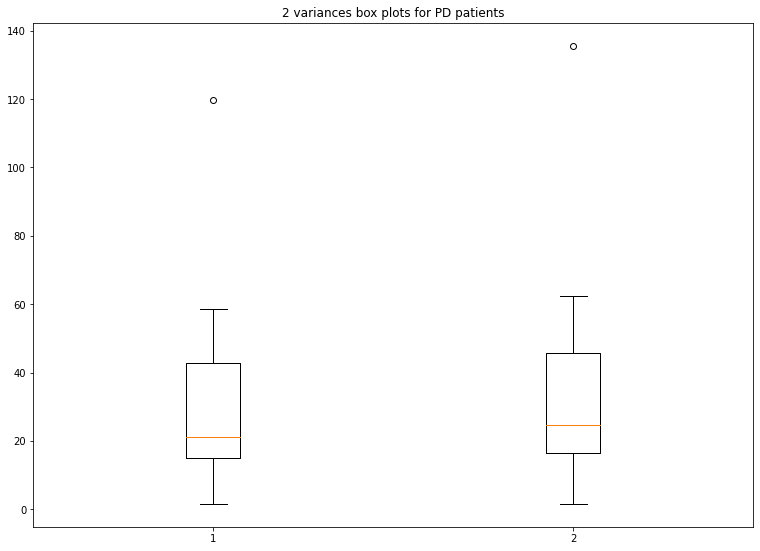

In [47]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(pd_feature)
ax.set_title('2 variances box plots for PD patients')

Text(0.5, 1.0, '2 variances box plots for ET and PD patients')

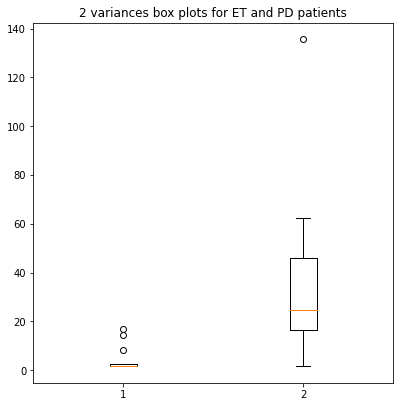

In [48]:
# plot side by side ET and PD
fig = plt.figure(figsize =(5,5))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot([et_feature[:,0], pd_feature[:,1]])
ax.set_title('2 variances box plots for ET and PD patients')

Looks much more separable than previous data, however, there are several outliers in ET group.

## Histograms of the obtained features
Let's plot histograms for the patients with Parkinson and Tremor to see if they are separable.


2D histograms on the extracted features

In [ ]:
fig, axs = plt.subplots(2, 1, figsize = (10,5))
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i,:]) # back to whole data
    axs[0].hist2d(transformed_et[0],transformed_et[1])
for i in range(len(parkinson_data)):
    transformed_pd = calculate_2D(parkinson_data[i,:]) # back to whole data
    axs[1].hist2d(transformed_pd[0],transformed_pd[1])

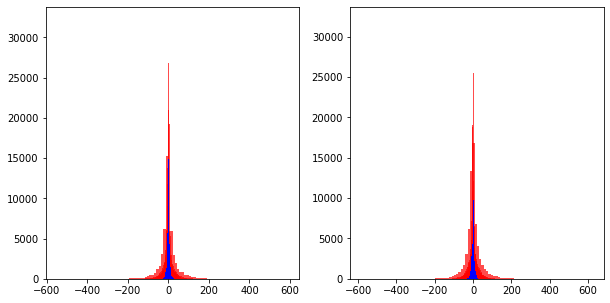

In [53]:
# 2 1D histograms : feature 1 and feature 2, red PD, blue ET
fig, axs = plt.subplots(1,2, figsize = (10,5))
for i in range(len(parkinson_data)):
    transformed_pd = calculate_2D(parkinson_data[i,:]) # back to whole data
    axs[0].hist(transformed_pd[0], bins = 100, color= 'r', alpha = 0.7)
    axs[1].hist(transformed_pd[1], bins = 100, color= 'r', alpha = 0.7)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i,:]) # back to whole data
    axs[0].hist(transformed_et[0], bins = 100, color= 'b')
    axs[1].hist(transformed_et[1], bins = 100, color= 'b')

(array([1., 4., 3., 2., 1., 1., 4., 0., 1., 1., 1., 0., 0., 0., 1.]),
 array([ 1.62526953,  7.01520312, 12.40513672, 17.79507031, 23.1850039 ,
        28.5749375 , 33.96487109, 39.35480468, 44.74473828, 50.13467187,
        55.52460547, 60.91453906, 66.30447265, 71.69440625, 77.08433984,
        82.47427343]),
 <BarContainer object of 15 artists>)

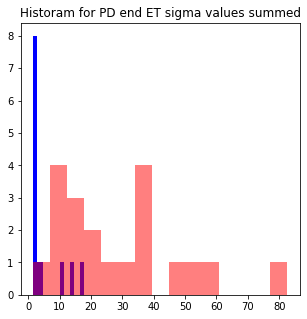

<Figure size 800x800 with 0 Axes>

In [51]:
### If we will plot the histogrmas of the variability directly
et_transformed_std = np.zeros((len(et_data),2))
pd_transformed_std = np.zeros((len(parkinson_data),2))
fig, ax = plt.subplots(figsize=(5, 5))
plt.figure(figsize=(10, 10), dpi=80)
for i in range(len(et_data)):
    transformed_et = calculate_2D(et_data[i,:])
   # get the std for transformed data
    std = np.std(transformed_et,1)
    et_transformed_std[i,:]=std[0],std[1]
for i in range(len(parkinson_data)):
    transformed_pd = calculate_2D(parkinson_data[i,:]) # back to whole data
    std = np.std(transformed_pd,1)
    pd_transformed_std[i,:]=std[0],std[1]
#NB I sum the features over 2 dimenstions 
ax.set_title('Historam for PD end ET sigma values summed')
ax.hist(et_transformed_std[:,1]+et_transformed_std[:,0], bins =15, color ='b')
ax.hist(pd_transformed_std[:,1]+pd_transformed_std[:,0], bins = 15,color ='r', alpha = 0.5)

### help cell to save data

In [ ]:
# save the data for another test wiht Bayesian Network
n = 0
import csv
with open("parkinson_et.csv", "w+") as file:
    writer = csv.writer(file)
    writer.writerow(['P','EMG1','EMG2','EMG3','EMG4','D'])
    for i in range(len(data.Y)):        
        patient = data.X[i][0]
        fig, ax = plt.subplots(figsize=(20,3))
        ax.plot(patient)
        plt.show()
        print(f'Enter the coordinates of selected signal part (START, END) for patient {data.Y[i]}:')
        x = input()
        values = x.split(',')
        values = [int(values[0]), int(values[1])]
        fig, ax = plt.subplots(figsize=(20,3))
        ax.plot(patient, 'b', alpha = 0.3)
        ax.vlines([values[0], values[1]], -100, 100, linestyles='dashed', colors='red')
        fig.show()
        if data.Y[i]=='ET':
            for j in range(values[0], values[1]):
                one_time =  data.X[i][:,j]
                writer.writerow([n,one_time[0],one_time[1],one_time[2],one_time[3],'ET'])
            n+=1
        elif data.Y[i]=='Left' or data.Y[i]=='Right':
             for j in range(values[0], values[1]):
                one_time =  data.X[i][:,j]
                writer.writerow([n,one_time[0],one_time[1],one_time[2],one_time[3],'PD'])
             n+=1
        elif data.Y[i]=='Control':
             for j in range(values[0], values[1]):
                one_time =  data.X[i][:,j]
                writer.writerow([n,one_time[0],one_time[1],one_time[2],one_time[3],'Control'])
             n+=1


# Conclusion:
It is impossible to seprate the patients using the proposed feature with the parameters, proposed in the paper.

# Implement SVM on the given features (mu and sigma) - TODO